In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.stats import boxcox

pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [3]:
df_train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_train.shape

(1460, 81)

In [4]:
df_test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
df_test.shape

(1459, 80)

In [5]:
ordinal_map1 = {'No':0,'NA':0,'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
other_mappings = {
    "Alley" : {"Grvl" : 1, "Pave" : 2},
    "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
    "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,"ALQ" : 5, "GLQ" : 6},
    "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
    "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
    "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
    "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
    "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
    "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
    "Street" : {"Grvl" : 1, "Pave" : 2},
    "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}
}


In [6]:
#Combine train and test set to do one hot encoding together and then split it again

df_train['is_train'] = 1
df_test['is_train'] = 0
full_df = pd.concat([df_train, df_test], sort=False)

# One-hot encode
full_df = pd.get_dummies(full_df, drop_first=True)

# Split back
df_train_new = full_df[full_df['is_train'] == 1].drop('is_train', axis=1)
df_test_new = full_df[full_df['is_train'] == 0].drop('is_train', axis=1)

In [7]:
#Function to preprocess data

def preprocess_data(df, is_train=True):
    df = df.copy()

    # Drop high null columns
    drop_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType', 'FireplaceQu'
                             ,'3SsnPorch', 'LowQualFinSF','MiscVal', 'PoolArea']
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

# Handle missing categorical
    cat_na_cols = ["GarageType", "GarageFinish", "GarageQual", "GarageCond",
                    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
    for col in cat_na_cols:
        if col in df.columns:
            df[col] = df[col].fillna("NA")

    # Handle missing numeric
    for col in ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # Log transform
    log_cols = ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'LotArea', 'MSSubClass', 
                'MasVnrArea', 'OpenPorchSF', 'SalePrice', 'WoodDeckSF',
                'BsmtFinSF2', 'BsmtHalfBath', 'EnclosedPorch', 'ScreenPorch']
    for col in log_cols:
        if col in df.columns:
            df[col] = np.log1p(df[col])

    # Box-Cox transformation
    for col in ['BsmtFinSF1', 'TotalBsmtSF', 'BsmtUnfSF']:
        if col in df.columns:
            df[col] = df[col].fillna(0)
            df[col], _ = boxcox(df[col] + 1)

    # Convert to categorical
    if 'KitchenAbvGr' in df.columns:
        df['KitchenAbvGr'] = df['KitchenAbvGr'].astype(str)


    # Ordinal encoding
    ordinal_cols1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond','HeatingQC',
                     'KitchenQual','GarageQual','GarageCond']
    for col in ordinal_cols1:
        if col in df.columns:
            df[col] = df[col].map(ordinal_map1)

    # Other mappings
    for col, mapping in other_mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping)

    # Feature engineering
    if all(col in df.columns for col in ['YrSold', 'YearBuilt']):
        df['Age'] = df['YrSold'] - df['YearBuilt']
    if all(col in df.columns for col in ['YearBuilt', 'YearRemodAdd']):
        df['WasRemodeled'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)
    if all(col in df.columns for col in ['YrSold', 'YearRemodAdd']):
        df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']

    # Drop unused year cols
    for col in ['YearBuilt', 'YearRemodAdd', 'YrSold']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    # Convert to categorical
    if 'MSSubClass' in df.columns:
        df['MSSubClass'] = df['MSSubClass'].astype(str)
    if 'MoSold' in df.columns:
        df['MoSold'] = df['MoSold'].astype(str)

    
    return df


In [8]:

df_train_processed = preprocess_data(df_train_new)
df_test_processed = preprocess_data(df_test_new, is_train=False)

In [9]:
X_train = df_train_processed.drop(columns=['SalePrice'])
y_train = df_train_processed['SalePrice']

X_test = df_test_processed.drop(columns=['SalePrice'])

In [10]:
# Check nulls in test set
test_null = X_test.isnull().sum().sort_values(ascending = False)
test_null = test_null[test_null>0]
print(test_null)

BsmtHalfBath    2
BsmtFullBath    2
GarageCars      1
GarageArea      1
BsmtFinSF2      1
dtype: int64


In [11]:
#Remove nulls in test not addressed above
for col in test_null.index.tolist():
    X_test[col] = X_test[col].fillna(X_test[col].median())

In [12]:
test_null = X_test.isnull().sum().sort_values(ascending = False)
test_null = test_null[test_null>0]
print(test_null)

Series([], dtype: int64)


In [13]:
train_cols = set(df_train_processed.columns)
test_cols = set(df_test_processed.columns)

# Columns present in train but not in test
train_only = train_cols - test_cols

# Columns present in test but not in train
test_only = test_cols - train_cols

print("Columns in train but not in test:", train_only)
print("Columns in test but not in train:", test_only)

Columns in train but not in test: set()
Columns in test but not in train: set()


###  Ridge Model

In [14]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=10)  # use the best alpha you found earlier
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
final_preds = np.expm1(y_pred)


In [15]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_model.coef_
})
coef_df['AbsCoef'] = coef_df['Coefficient'].abs()
coef_df.sort_values(by='AbsCoef', ascending=False, inplace=True)


### Coefficient Matrix

In [16]:
coef_df.head(15)

,Feature,Coefficient,AbsCoef
13,GrLivArea,0.209,0.209
11,1stFlrSF,0.115,0.115
54,Neighborhood_Crawfor,0.093,0.093
70,Neighborhood_StoneBr,0.089,0.089
3,LotArea,0.082,0.082
84,Condition2_PosN,-0.081,0.081
55,Neighborhood_Edwards,-0.076,0.076
57,Neighborhood_IDOTRR,-0.073,0.073
63,Neighborhood_NoRidge,0.073,0.073
64,Neighborhood_NridgHt,0.071,0.071


GrLivArea and 1stFlrSF are strong predictors — intuitive since more living space usually means higher price.

Neighborhood effects are significant — being in Crawfor, StoneBr, or NridgHt adds value; 

### Submission

In [17]:
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': final_preds
})

submission.to_csv('submission.csv', index=False)


### Analyze Residuals

### Steps:
1.Split training data, calculate presiduals on test/train set and plot it

In [18]:
# X_train
# y_train

from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_train,y_train,test_size=0.30, random_state=1)
print("X_train.shape", X_train_1.shape, "y_train.shape", y_train_1.shape)
print("X_test.shape", X_test_1.shape, "y_test.shape", y_test_1.shape)


X_train.shape (1022, 241) y_train.shape (1022,)
X_test.shape (438, 241) y_test.shape (438,)


In [19]:
# Ridge
from sklearn.metrics import mean_squared_error

alpha = 10

ridge = Ridge(alpha=alpha)
ridge.fit(X_train_1, y_train_1)
y_pred_1 = ridge.predict(X_test_1)
# final_preds = np.expm1(y_pred)

# RSE: sqrt(Sum of Squares of Residuals / degrees of freedom)
rss = np.sum((y_test_1 - y_pred_1) ** 2)
rse = np.sqrt(rss / (len(y_test_1) - X_test_1.shape[1] - 1))  # df = n - p - 1

rmse = mean_squared_error(y_test_1, y_pred_1, squared=False)
print(f"Alpha: {alpha:>5} | R^2: {ridge.score(X_test_1, y_test_1):.4f} | RMSE: {rmse:.4f} | RSE: {rse:.4f}")


Alpha:    10 | R^2: 0.8958 | RMSE: 0.1403 | RSE: 0.2098


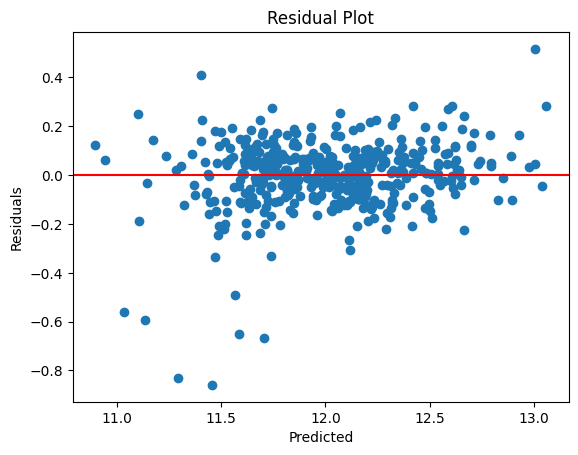

In [20]:
#Residuals

import matplotlib.pyplot as plt

residuals = y_test_1 - y_pred_1
plt.scatter(y_pred_1, residuals)
plt.axhline(0, color='red')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [21]:
# Grouping residuals
residual_df = X_test_1.copy()

residual_df['y_true'] = y_test_1
residual_df['y_pred'] = y_pred_1
residual_df['residual'] = residuals

# Example subgroup: High vs Low actual price
residual_df['price_group'] = pd.qcut(residual_df['y_true'], q=4, labels=['Low', 'Mid-Low', 'Mid-High', 'High'])

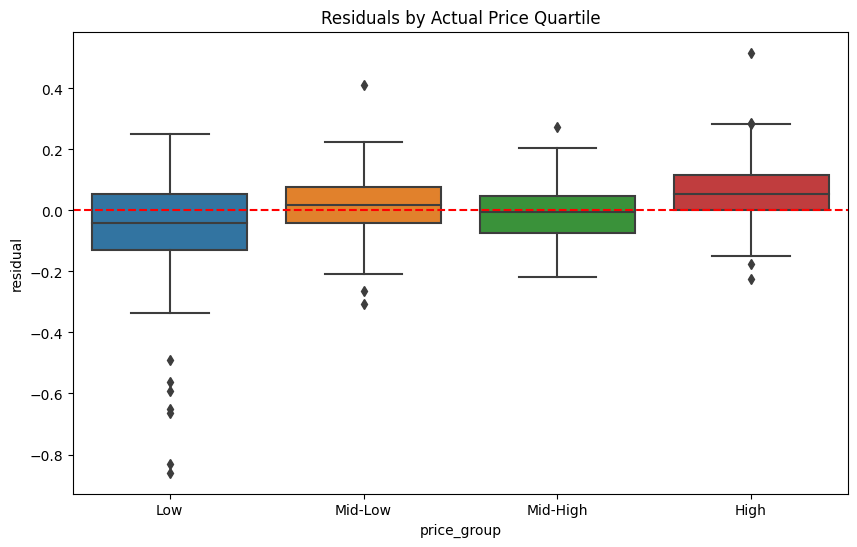

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(x='price_group', y='residual', data=residual_df)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals by Actual Price Quartile')
plt.show()


In [23]:
group_stats = residual_df.groupby('price_group')['residual'].agg(['mean', 'std', 'count'])
print(group_stats)


              mean   std  count
price_group                    
Low         -0.070 0.197    110
Mid-Low      0.016 0.101    109
Mid-High    -0.007 0.094    110
High         0.062 0.111    109
